In [ ]:
#Run this in your machine before working with the model to install it:
!pip install pygsl

In [ ]:
import nest
nest.set_verbosity('M_ERROR')

from pynestml.frontend.pynestml_frontend import generate_nest_target


generate_nest_target(input_path="models/adex_gamma_E.nestml",   # file containing the neuron model definition
                     suffix="_ml",                               # append to model name to avoid clash with existing model
                     module_name="m1module",                     # enumerate modules; name must end in "module"
                     target_path="tgt",                          # path for auxiliary files generated by NESTML
                     install_path=".")                           # location for generated module; must be "." on EBRAINS

nest.Install('m1module')

In [406]:
import nest.raster_plot
import nest.voltage_trace
import numpy as np
import matplotlib.pyplot as plt
nest.ResetKernel()
nest.resolution = 0.1
%matplotlib inline
rt = nest.GetDefaults('adex_gamma_E_ml', 'receptor_types')

duration = 1000

# Define pop numbers
N_E = 160
N_I = 40

net = (2*N_E)+(2*N_I)
n_populations = 4

max = 1.6  # size of the array (in mm)
min = -1.6

positions = nest.spatial.free(
    nest.random.uniform(min=min, max=max),  # using random positions in a uniform distribution
    num_dimensions=2)  # have to specify number of dimensions

mechanisms = ["I_AMPA", "I_GABA"]

# Define Synaptic Weights
nmdaW = 1.0
ampaW = 5
gabaW = -3.34

# Set non-uniform initial membrane voltage
VmProbE = np.random.uniform(low=-65, high=-50, size=N_E)
VmProbI= np.random.uniform(low=-65, high=-50, size=N_I)

# Define syn params
stim_syn = {'weight': nest.random.lognormal(mean=0.7, std=0.1), 'receptor_type': rt['AMPA'], 'delay':1.5}
noise_synE = {'weight': nest.random.lognormal(mean=0.2, std=0.05), 'receptor_type': rt['AMPA'], 'delay':1.5}
noise_synI = {'weight': nest.random.lognormal(mean=-0.2, std=0.05), 'receptor_type': rt['GABA'], 'delay':1.5}
EEsyn = nest.CollocatedSynapses({'weight': ampaW, 'receptor_type': rt['AMPA'], 'delay': 1.5},
                                {'weight': 0.4, 'receptor_type': rt['NMDA'], 'delay': 1.5})
EIsyn = nest.CollocatedSynapses({'weight': ampaW, 'receptor_type': rt['AMPA'], 'delay': 1.5},
                                {'weight': 0.25, 'receptor_type': rt['NMDA'], 'delay': 1.5})

localIsyn = {'weight': gabaW, 'receptor_type': rt['GABA'], 'delay': 1.5}
distIsyn = {'weight': gabaW, 'receptor_type': rt['GABA'], 'delay': 1.5}


# Define conn params
connEE = {'rule': 'pairwise_bernoulli', 'p': 0.65, 'allow_autapses': False}
connEI = {'rule': 'pairwise_bernoulli', 'p': 0.5}
connIE = {'rule': 'pairwise_bernoulli', 'p': 0.6}
connStim = {'rule': 'pairwise_bernoulli', 'p': 0.2}

neuron_populations = []

# Create cells
E1 = nest.Create('adex_gamma_E_ml', N_E, params={'V_m': VmProbE})
neuron_populations.append(E1)
E2 = nest.Create('adex_gamma_E_ml', N_E, params={'V_m': VmProbE})
neuron_populations.append(E2)
I1 = nest.Create('adex_gamma_E_ml', N_I, params={'V_th':-47.5, 'V_peak':-37.5,'a': 0, 'b':0,'Delta_T': 0.5, 'V_m': VmProbI})
neuron_populations.append(I1)
I2 = nest.Create('adex_gamma_E_ml', N_I, params={'V_th':-47.5, 'V_peak':-37.5,'a': 0, 'b':0,'Delta_T': 0.5, 'V_m': VmProbI})
neuron_populations.append(I2)



# Create devices
pg = nest.Create("poisson_generator", {'rate':35000})
noise1 = nest.Create("poisson_generator", {'rate':1500})
noise2 = nest.Create("poisson_generator", {'rate':1500})
E1spk = nest.Create('spike_recorder')
I1spk = nest.Create('spike_recorder')
E2spk = nest.Create('spike_recorder')
I2spk = nest.Create('spike_recorder')




# Connect devices
nest.Connect(E1, E1spk)
nest.Connect(I1, I1spk)
nest.Connect(E2, E2spk)
nest.Connect(I2, I2spk)

# stim syns
nest.Connect(pg, E1, syn_spec=stim_syn, conn_spec=connStim)
nest.Connect(pg, I1, syn_spec=stim_syn, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.125})


nest.Connect(E1, E2, syn_spec=EEsyn, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.8,  'allow_autapses': False})
nest.Connect(E1, E1, syn_spec=EEsyn, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.1,  'allow_autapses': False})
nest.Connect(E2, E1, syn_spec=EEsyn, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.35,  'allow_autapses': False}) 
nest.Connect(E2, E2, syn_spec=EEsyn, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.15,  'allow_autapses': False})

# EI syns
nest.Connect(E1, I2, syn_spec=EIsyn, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.5,  'allow_autapses': False}) 
nest.Connect(E1, I1, syn_spec=EIsyn, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.2,  'allow_autapses': False}) 
nest.Connect(E2, I1, syn_spec=EIsyn, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.65,  'allow_autapses': False}) 
nest.Connect(E2, I2, syn_spec=EIsyn, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.2,  'allow_autapses': False}) 

# IE syns
nest.Connect(I1, E1, syn_spec=localIsyn, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.55,  'allow_autapses': False}) #prev 0.385
nest.Connect(I1, E2, syn_spec=distIsyn, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.2,  'allow_autapses': False}) 
nest.Connect(I2, E1, syn_spec=distIsyn, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.2,  'allow_autapses': False}) #prev 0.425
nest.Connect(I2, E2, syn_spec=localIsyn, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.5,  'allow_autapses': False}) 

# II syns
nest.Connect(I2, I2, syn_spec=localIsyn, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.1,  'allow_autapses': False})
nest.Connect(I1, I1, syn_spec=localIsyn, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.1,  'allow_autapses': False})

In [407]:
nest.Simulate(duration)

In [408]:
spkct = len(E2spk.events['times'])+len(E1spk.events['times'])+len(I2spk.events['times'])+len(I1spk.events['times'])
rate_net = spkct / duration * 1000.0 / net
rate_net

36.275

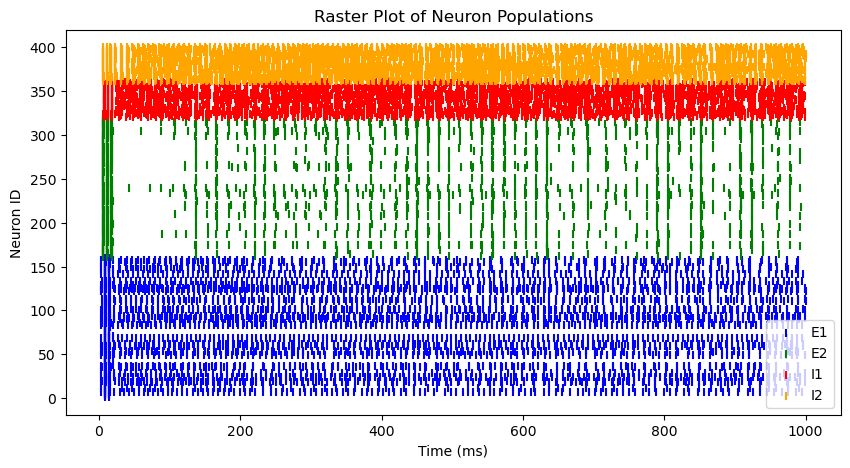

In [409]:
timesE1 = nest.GetStatus(E1spk, "events")[0]["times"]
sendersE1 = nest.GetStatus(E1spk, "events")[0]["senders"]

timesE2 = nest.GetStatus(E2spk, "events")[0]["times"]
sendersE2 = nest.GetStatus(E2spk, "events")[0]["senders"]

timesI1 = nest.GetStatus(I1spk, "events")[0]["times"]
sendersI1 = nest.GetStatus(I1spk, "events")[0]["senders"]

timesI2 = nest.GetStatus(I2spk, "events")[0]["times"]
sendersI2 = nest.GetStatus(I2spk, "events")[0]["senders"]

# Create a raster plot with different colors for each population
plt.figure(figsize=(10, 5))
plt.scatter(timesE1, sendersE1, marker="|", color="blue", label="E1")
plt.scatter(timesE2, sendersE2, marker="|", color="green", label="E2")  
plt.scatter(timesI1, sendersI1, marker="|", color="red", label="I1")
plt.scatter(timesI2, sendersI2, marker="|", color="orange", label="I2") 
plt.title("Raster Plot of Neuron Populations")
plt.xlabel("Time (ms)")
plt.ylabel("Neuron ID")
# plt.xlim(0, 1000)
# plt.ylim(0, 200)  # Adjust the y-axis limit based on the total number of neurons
plt.legend(loc='lower right')
plt.show()

In [410]:
NeuronIDE1 = np.array(sendersE1)
NeuronIDI1 = np.array(sendersI1)

timeE1=np.array(timesE1) #time in ms
timeI1=np.array(timesI1)

Xloc, Yloc = np.random.rand(2, 400) * np.array([[max, min]]).T

time_resolution = 1  # time resolution
npts = int(duration / time_resolution)  # nb points in LFP vector

xe = max / 2
ye = max / 2  # coordinates of electrode

va = 200  # axonal velocity (mm/sec)
lambda_ = 0.2  # space constant (mm)
dur = 100  # total duration of LFP waveform
nlfp = int(dur / time_resolution)  # nb of LFP pts
amp_e = 0.7  # uLFP amplitude for exc cells
amp_i = -3.4  # uLFP amplitude for inh cells
sig_i = 2.1  # std-dev of ihibition (in ms)
sig_e = 1.5 * sig_i  # std-dev for excitation

# amp_e = -0.16	# exc uLFP amplitude (deep layer)
# amp_i = -0.2	# inh uLFP amplitude (deep layer)

amp_e = 0.48  # exc uLFP amplitude (soma layer)
amp_i = 3  # inh uLFP amplitude (soma layer)

# amp_e = 0.24	# exc uLFP amplitude (superficial layer)
# amp_i = -1.2	# inh uLFP amplitude (superficial layer)

# amp_e = -0.08	# exc uLFP amplitude (surface)
# amp_i = 0.3	# inh uLFP amplitude (surface)

dist = np.sqrt((Xloc - xe) ** 2 + (Yloc - ye) ** 2)  # distance to  electrode in mm
delay = 10.4 + dist / va  # delay to peak (in ms)
amp = np.exp(-dist / lambda_)
amp[:N_E] *= amp_e
amp[N_I:] *= amp_i

s_e = 2 * sig_e * sig_e
s_i = 2 * sig_i * sig_i


Time_LFP= (np.arange(npts) * time_resolution) #in ms

#=======================================

def f_temporal_kernel(t, tau):
    """function defining temporal part of the kernel"""
    return np.exp(-(t ** 2) / tau)


#=======================================
def calc_lfp(cells_time,cells_id,tau):
    """Calculate LFP from cells"""

    # this is a vectorised computation and as such it might be memory hungry
    # for long LFP series/large number of cells it may be more efficient to calculate it through looping

    spt = cells_time
    cid = cells_id
    
    kernel_contribs = amp[None, cid] * f_temporal_kernel(
        Time_LFP[:, None] - delay[None, cid] - spt[None, :], tau
    )
    lfp = kernel_contribs.sum(1)
    return lfp

#=======================================

lfp_E = calc_lfp(timeE1,NeuronIDE1,s_e)
lfp_I = calc_lfp(timeI1,NeuronIDI1,s_i)

LFP = lfp_E + lfp_I 


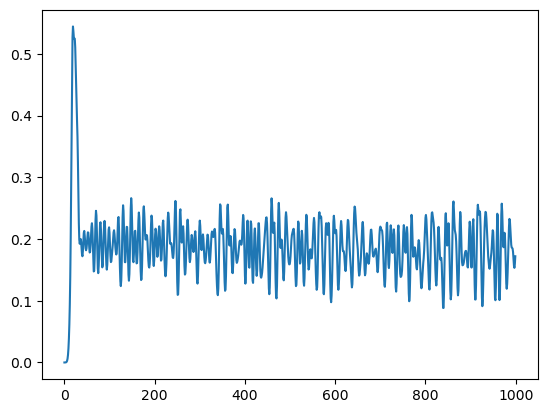

In [411]:
plt.plot(LFP)

In [412]:
from scipy import signal
def PowerSpectrum2(Signal,SamplingRate,Time_pSeg):

    freq, Power = signal.welch(Signal, SamplingRate, window='hamming', nperseg=Time_pSeg*SamplingRate, noverlap=int((Time_pSeg*SamplingRate)*0.5), scaling='spectrum')

    Normalization2=np.sqrt(np.sum(np.square(Power)))

    Normalization=np.sum(Power)

    PS_pick=freq[np.argmax(Power)]

    return freq,Power,Power/Normalization,Power/Normalization2,PS_pick

def ZscoreNorm(Signal):
    

    Signal_normalized=(Signal-np.mean(Signal))/np.std(Signal)

    return  Signal_normalized
def Main_2PicksAmp(x,y,Prominence):

    Allpeak_indexes, _ = find_peaks(y, prominence=Prominence)
    Allpeaks=y[Allpeak_indexes]
    time_peaks=x[Allpeak_indexes]
    ordered_indexes=Allpeaks.argsort()
    timePeaks_Ordered=time_peaks[ordered_indexes]
    Allpeaks_Ordered=Allpeaks[ordered_indexes]

    if(time_peaks.size>=2):
        first_pick=timePeaks_Ordered[-1]; second_pick=timePeaks_Ordered[-2]
        Amp_firstP=Allpeaks_Ordered[-1];  Amp_secondP=Allpeaks_Ordered[-2]
        
    if(time_peaks.size==1):
        first_pick=timePeaks_Ordered[-1]; second_pick=np.nan
        Amp_firstP=Allpeaks_Ordered[-1]; Amp_secondP=np.nan
        
    if not time_peaks.size: #If the array is empty
        first_pick=np.nan; second_pick=np.nan
        Amp_firstP=np.nan; Amp_secondP=np.nan

    return first_pick,second_pick,Amp_firstP,Amp_secondP

def SignalPhase_byHilbert(Signal, Signal_time, lowcut, highcut,SamplingSpace):

    Signal = Signal-np.mean(Signal)

    width = 5.0 #The desired width in Hz of the transition from pass to stop
    ripple_db = 60.0 # The desired attenuation in the stop band, in dB.
    SamplingRate=1./SamplingSpace
    Nyquist=SamplingRate/2.

    time_Filtered_Signal, Filtered_Signal, Signal_thatOverLaps_FileteredOne= Keiser_bandpass(Signal, Signal_time, lowcut, highcut, ripple_db, width, Nyquist,SamplingRate)#Use everithing in seconds to obtain in seconds

    #--------------------------------------------------------------------------
    #The hilbert transform are very slow when the signal has odd lenght,
    #for this reason I check, and if this is the case I add a zero in the end of all the vectors
    #related to the filtered Signal:

    if(len(Filtered_Signal)%2!=0):#If the lengh is odd
        tmp1=Filtered_Signal.tolist(); tmp1.append(0)
        tmp2=time_Filtered_Signal.tolist(); tmp2.append((len(time_Filtered_Signal)+1)*SamplingSpace + time_Filtered_Signal[0])
        tmp3=Signal_thatOverLaps_FileteredOne.tolist(); tmp3.append(0)
        Filtered_Signal=np.asarray(tmp1); time_Filtered_Signal=np.asarray(tmp2)
        Signal_thatOverLaps_FileteredOne=np.asarray(tmp3)
    #--------------------------------------------------------------------------
    
    HT_Filtered_Signal = signal.hilbert(Filtered_Signal); Envelope=np.abs(HT_Filtered_Signal)
    Phase=np.angle(HT_Filtered_Signal)#The phase comes between -pi and pi in radians
    #Phase_02pi=np.mod(Phase, 2*np.pi)#The phase comes between 0 and 2pi in radians, doesn't look it is working properly

    return time_Filtered_Signal,Filtered_Signal,Signal_thatOverLaps_FileteredOne,Envelope,Phase
def Keiser_bandpass(data, time, lowcut, highcut, ripple_db, width, Nyquist,SamplingRate):
    numtaps, beta = kaiserord(ripple_db, width/Nyquist)
    if(numtaps%2==0):
        numtaps=(numtaps+1) #Numtaps must be odd
    taps = firwin(numtaps,[lowcut/Nyquist, highcut/Nyquist], window=('kaiser', beta), nyq=1.0, pass_zero=False, scale=True) 
    filtered_data = lfilter(taps, 1.0, data)
    delay = 0.5 * (numtaps-1) /SamplingRate #To corrected to zero-phase
    delay_index=int(np.floor(delay*SamplingRate))
    filtered_data= filtered_data[numtaps-1:]#taking out the "corrupted" signal
    time_filteredData=time[numtaps-1:]-delay #correcting the delay and taking out the "corrupted" signal part
    data_thatOverLaps_FileteredOne= data[(numtaps-1-delay_index):(len(data)-(numtaps-1-delay_index))]


    return time_filteredData, filtered_data, data_thatOverLaps_FileteredOne

In [413]:
from scipy.signal import find_peaks
from scipy.signal import butter, filtfilt

Time_pSeg=0.25 #s

b, a = butter(4, [30 / (1000 / 2), 50 / (1000 / 2)], btype='band')

# Apply the filter to the LFP data using filtfilt to avoid phase distortion
filtered_lfpMid = filtfilt(b, a, LFP)

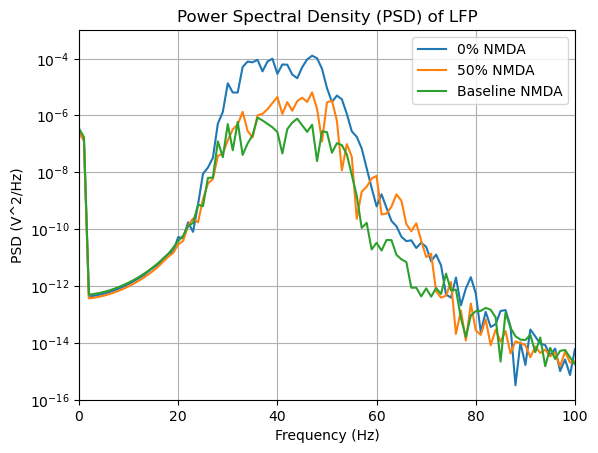

In [419]:
from scipy.signal import welch
# plt.xlim = 50
# plt.plot(Power)

frequencies, psdBase = welch(filtered_lfpBase, 1000, nperseg=1000)
frequencies, psdMid = welch(filtered_lfpMid, 1000, nperseg=1000)
frequencies, psdLow = welch(filtered_lfpLow, 1000, nperseg=1000)
fig=plt.figure()
ax=fig.add_subplot(111)
ax.semilogy(frequencies, psdLow, label = "0% NMDA")
ax.semilogy(frequencies, psdMid, label = "50% NMDA")
ax.semilogy(frequencies, psdBase, label = "Baseline NMDA")
ax.set_xlim(left=0.0,right=100)
ax.set_ylim(10**-16, 10**-3)
ax.legend()
plt.title('Power Spectral Density (PSD) of LFP')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V^2/Hz)')
ax.grid(True)
plt.show()

(100.0, 1000.0)

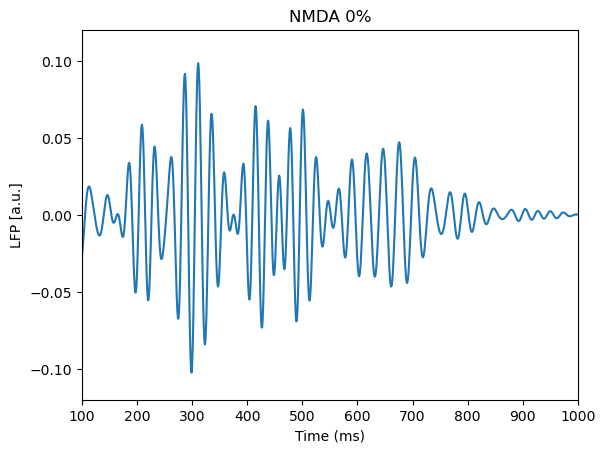

In [396]:
plt.plot(filtered_lfpLow)
plt.title('NMDA 0%')
plt.ylim(-0.12, 0.12)
plt.ylabel('LFP [a.u.]')
plt.xlabel('Time (ms)')
plt.xlim(100, 1000)